# Comparing models

In this notebook, we intend to compare the capacity of novel models to perform a simple multi-class classification task. The models being compared have vastly different hardware requirements, so they will be mainly compared in terms of their accuracy and parameter efficiency rather than energy expenditure. The following models will be explored in this notebook.

- MLP
- KAN
- SNN

## Downloading and visualizing the data

This experiment will use the FashionMNIST dataset

         Only Prophesee DVS demo will not run properly.
         Please install it from https://github.com/prophesee-ai/prophesee-automotive-dataset-toolbox
Running on cuda
Image size example: torch.Size([1, 28, 28]); Label example: 9


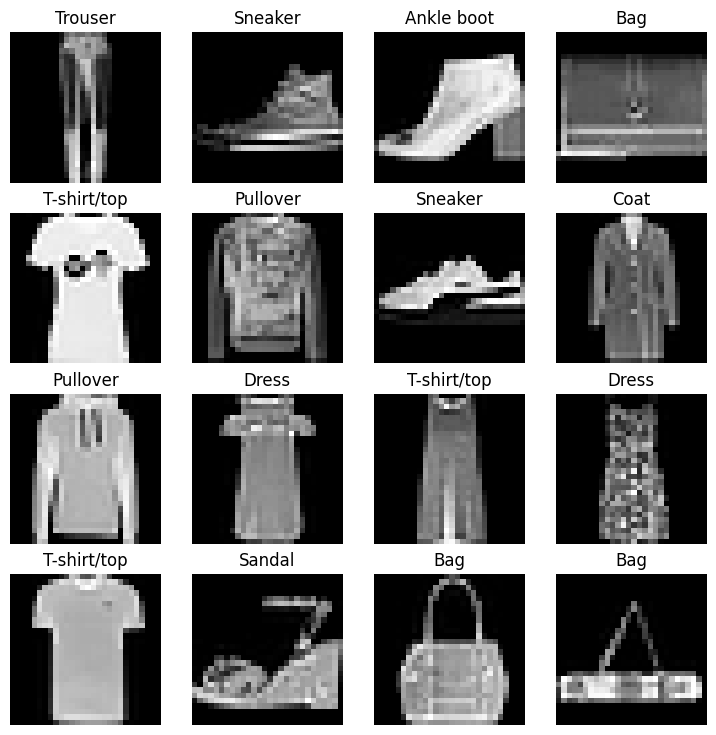

Created training and validation dataloaders with respectively 1500 and 375 batches of size 32


In [ ]:
###########
# Imports #
###########

# Import PyTorch
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import lava
import lava.lib.dl.slayer as slayer
import lava.lib.dl.bootstrap as bootstrap

# Import pyplot for visualization
import matplotlib.pyplot as plt

# Import utilities
from tqdm.auto import tqdm
from timeit import default_timer as timer
import math


##########
# Device #
##########

torch_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {torch_device}")

# Auxiliary function to set CPU and GPU seeds
def set_torch_seed(seed):
    torch.manual_seed(seed)
    if torch_device == "cuda": torch.cuda.manual_seed(seed)


#################
# Dataset setup #
#################

train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# Split into training and validation sets
set_torch_seed(42)
train_data, val_data = random_split(train_dataset, [0.8, 0.2])
class_names = train_dataset.classes

print(f"Image size example: {train_data[0][0].shape}; Label example: {train_data[0][1]}")

fig = plt.figure(figsize=(9, 9))
rows,cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=(1,)).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)
plt.show()

BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_dataloader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Created training and validation dataloaders with respectively {len(train_dataloader)} and {len(val_dataloader)} batches of size {BATCH_SIZE}")

## Training and evaluating models

We create an abstract class to represent models with methods to train and evaluate them

In [3]:
class SupervisedModel():
    """A representation of an ML model which can be built with PyTorch, Lava or whatever else"""
    def train(self, train_dataloader: DataLoader, val_dataloader: DataLoader=None) -> tuple:
        """Fits model to the given dataset"""
        return
    
    def evaluate(self, val_dataloader: DataLoader) -> tuple:
        """Returns the model average loss and accuracy in the given dataset"""
        return 0.0


class TorchSM(SupervisedModel):
    """A representation of an ML model built with PyTorch"""
    def __init__(self, model: torch.nn.Module, optim: torch.optim.Optimizer, loss_fn: torch.nn.Module, device):
        super().__init__()

        self.model = model.to(device)
        self.optim = optim
        self.loss_fn = loss_fn
        self.device = device


    def train(self, train_dataloader: DataLoader, val_dataloader: DataLoader=None, n_epochs=10) -> tuple:
        """Fits model to the given dataset"""
        training_losses, val_losses, val_accs = [], [], []

        train_start_time = timer() # Start timer

        if not val_dataloader is None:
            _, val_acc = self.evaluate(val_dataloader)
            val_accs.append(val_acc)
            print(f"Validation loss: {val_acc:.3f}%\n")

        for epoch in range(n_epochs):
            self.update_epoch(epoch)

            print(f"-----\nEpoch: {epoch+1} / {n_epochs}")

            # Training
            train_loss = 0.0
            for batch_idx, (X, y) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), unit=" batches", desc=f"Training {self.model._get_name()}"):
                self.update_batch(batch_idx)

                X, y = X.to(self.device), y.to(self.device)

                self.model.train()
                y_pred = self.model(X)

                loss = self.loss_fn(y_pred, y)
                train_loss += loss.cpu().detach()
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()
            avg_train_loss = train_loss / len(train_dataloader)
            training_losses.append(avg_train_loss)

            log = f"Train loss: {avg_train_loss:.3f}"

            # Validating
            if not val_dataloader is None:
                avg_val_loss, val_acc = self.evaluate(val_dataloader)
                val_losses.append(avg_val_loss)
                val_accs.append(val_acc)

                log += f" | Validation loss: {avg_val_loss:.3f} | Validation accuracy: {val_acc:.3f}%\n"
            
            print(log)
        
        train_stop_time = timer() # Stop timer
        training_elapsed_time = train_stop_time - train_start_time

        return training_elapsed_time, training_losses, val_losses, val_accs
        
    
    def evaluate(self, val_dataloader: DataLoader) -> tuple:
        """Returns the model average loss and accuracy in the given dataset"""
        val_loss, corrects = 0, 0
        self.model.eval()
        with torch.inference_mode():
            for batch_idx, (X, y) in tqdm(enumerate(val_dataloader), total=len(val_dataloader), unit=" batches", desc=f"Evaluating {self.model._get_name()}"):
                self.update_batch(batch_idx)
                
                X, y = X.to(self.device), y.to(self.device)
                y_pred = self.model(X)
                loss = self.loss_fn(y_pred, y)

                val_loss += loss.cpu().detach()

                y_label_pred = y_pred.argmax(dim=1)
                correct = torch.eq(y_label_pred, y).sum().item()
                corrects += correct
        avg_val_loss = val_loss / len(val_dataloader)
        val_acc = corrects / len(val_dataloader) / val_dataloader.batch_size * 100

        return avg_val_loss, val_acc
    

    def update_epoch(self, epoch):
        """Can be extended by the SNN model to account for the scheduler"""
        pass

    
    def update_batch(self, batch):
        """Can be extended by the SNN model to account for the scheduler"""
        pass


class SNNSM(TorchSM):
    def update_epoch(self, epoch):
        """Can be extended by the SNN model to account for the scheduler"""
        self.model.epoch = epoch

    
    def update_batch(self, batch):
        """Can be extended by the SNN model to account for the scheduler"""
        self.model.batch = batch

We also define a function for plotting the losses and accuracy on pyplot so we can visualize the performances of the trained models

In [4]:
def visualize_model_training(training_elapsed_time: float, training_losses: list, val_losses: list, val_accs: list, model_name: str):
    print(f"Trained {model_name} for {len(training_losses)} epochs in {training_elapsed_time:.3f}s")

    loss_epoch_indices = range(1, len(training_losses) + 1)
    acc_epoch_indices = range(0, len(training_losses) + 1)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    # Plot losses on primary y-axis
    ax1.set_ylabel("Loss")
    ax1.plot(loss_epoch_indices, training_losses, label="Train loss")
    ax1.plot(loss_epoch_indices, val_losses, label="Validation loss")
    ax1.set_xlabel("Epochs")

    # Plot accuracy on secondary y-axis
    ax2.set_ylabel("Validation accuracy")
    ax2.plot(acc_epoch_indices, val_accs, 'r--', label="Validation accuracies")

    plt.title(f"Results for training of {model_name}")
    ax1.legend(loc="lower left")
    ax2.legend(loc="upper right")

## Multilayer Perceptron (MLP)

We first train and plot the results of the MLP on the FashionMNIST dataset

In [5]:
class MLP(nn.Module):
    """MLP for image classification with a configurable number of hidden features"""
    def __init__(self, input_shape: int, hidden_features: int, output_shape: int):
        super().__init__()

        self.sequential = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_features),
            nn.Linear(hidden_features, output_shape)
        )
    

    def forward(self, X):
        return self.sequential(X)

# Train model
mlp = MLP(28 * 28, 10, len(class_names))
mlp_optim = optim.SGD(mlp.parameters(), 0.1)
mlp_loss_fn = torch.nn.CrossEntropyLoss()
mlp_model = TorchSM(mlp, mlp_optim, mlp_loss_fn, torch_device)

mlp_training_elapsed_time, mlp_training_losses, mlp_val_losses, mlp_val_accs = mlp_model.train(train_dataloader, val_dataloader)

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 16.917%

-----
Epoch: 1 / 10


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.611 | Validation loss: 0.517 | Validation accuracy: 82.517%

-----
Epoch: 2 / 10


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.482 | Validation loss: 0.474 | Validation accuracy: 83.575%

-----
Epoch: 3 / 10


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.459 | Validation loss: 0.478 | Validation accuracy: 83.125%

-----
Epoch: 4 / 10


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.446 | Validation loss: 0.468 | Validation accuracy: 84.033%

-----
Epoch: 5 / 10


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.437 | Validation loss: 0.449 | Validation accuracy: 84.533%

-----
Epoch: 6 / 10


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.430 | Validation loss: 0.474 | Validation accuracy: 83.592%

-----
Epoch: 7 / 10


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.425 | Validation loss: 0.470 | Validation accuracy: 84.467%

-----
Epoch: 8 / 10


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.423 | Validation loss: 0.449 | Validation accuracy: 84.883%

-----
Epoch: 9 / 10


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.418 | Validation loss: 0.456 | Validation accuracy: 84.342%

-----
Epoch: 10 / 10


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.415 | Validation loss: 0.470 | Validation accuracy: 83.567%



Trained MLP for 10 epochs in 41.065s


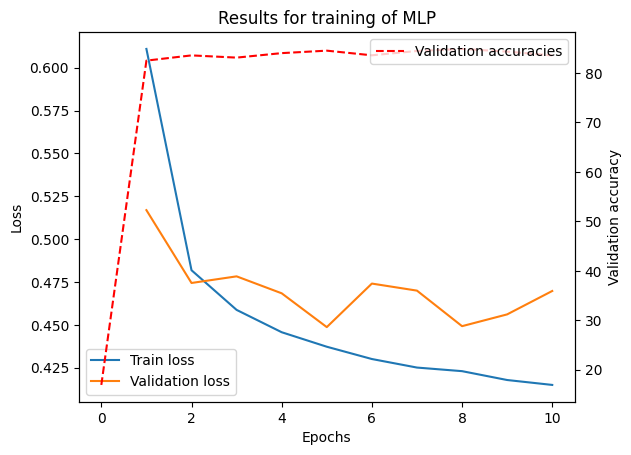

In [6]:
# Visualize results
visualize_model_training(mlp_training_elapsed_time, mlp_training_losses, mlp_val_losses, mlp_val_accs, "MLP")

## Kolmogorov-Arnold Network (KAN)

We train and plot the results of the KAN on the FashionMNIST dataset

In [7]:
"""KAN implementation from https://github.com/Blealtan/efficient-kan/blob/master/src/efficient_kan/kan.py"""

class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [8]:
class ImageKAN(KAN):
    def __init__(self, layers_hidden, grid_size=5, spline_order=3, scale_noise=0.1, scale_base=1, scale_spline=1, base_activation=torch.nn.SiLU, grid_eps=0.02, grid_range=[-1, 1]):
        super().__init__(layers_hidden, grid_size, spline_order, scale_noise, scale_base, scale_spline, base_activation, grid_eps, grid_range)
        self.flatten = nn.Flatten()
    

    def forward(self, x: torch.Tensor, update_grid=False):
        return super().forward(self.flatten(x), update_grid)


kan = ImageKAN([28 * 28, 64, 10])
kan_optim = optim.AdamW(kan.parameters(), lr=0.001, weight_decay=0.0001)
kan_loss_fn = nn.CrossEntropyLoss()
kan_model = TorchSM(kan, kan_optim, kan_loss_fn, torch_device)


kan_training_elapsed_time, kan_training_losses, kan_val_losses, kan_val_accs = kan_model.train(train_dataloader, val_dataloader)

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 9.925%

-----
Epoch: 1 / 10


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.519 | Validation loss: 0.399 | Validation accuracy: 85.900%

-----
Epoch: 2 / 10


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.371 | Validation loss: 0.369 | Validation accuracy: 86.875%

-----
Epoch: 3 / 10


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.335 | Validation loss: 0.338 | Validation accuracy: 87.817%

-----
Epoch: 4 / 10


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.308 | Validation loss: 0.339 | Validation accuracy: 87.725%

-----
Epoch: 5 / 10


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.289 | Validation loss: 0.332 | Validation accuracy: 87.783%

-----
Epoch: 6 / 10


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.273 | Validation loss: 0.329 | Validation accuracy: 88.033%

-----
Epoch: 7 / 10


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.261 | Validation loss: 0.325 | Validation accuracy: 88.300%

-----
Epoch: 8 / 10


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.246 | Validation loss: 0.332 | Validation accuracy: 88.217%

-----
Epoch: 9 / 10


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.236 | Validation loss: 0.314 | Validation accuracy: 88.875%

-----
Epoch: 10 / 10


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.226 | Validation loss: 0.317 | Validation accuracy: 89.000%



Trained KAN for 10 epochs in 71.395s


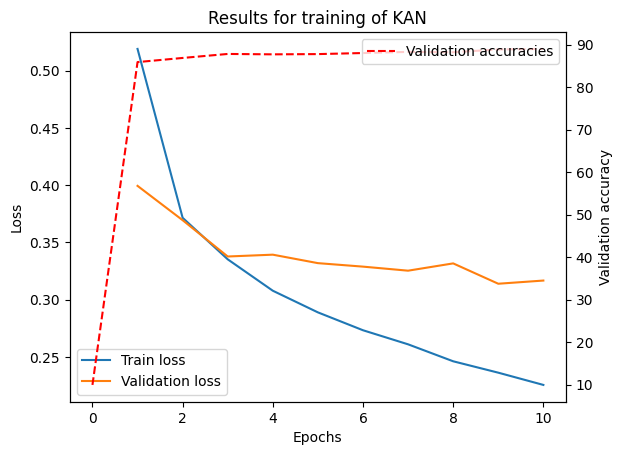

In [9]:
# Visualize results
visualize_model_training(kan_training_elapsed_time, kan_training_losses, kan_val_losses, kan_val_accs, "KAN")

## Spiking Neural Network (SNN)

We train and visualize the results of the SNN on the FashionMNIST dataset. 

NOTE: Couldn't get this to run on GPU

In [12]:
"""SNN implementation from https://github.com/lava-nc/lava-dl/blob/main/tutorials/lava/lib/dl/bootstrap/mnist/train.ipynb"""

class SNN(torch.nn.Module):
    def __init__(self, hidden_features, time_steps=16):
        super(SNN, self).__init__()
        self.time_steps = time_steps

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 1, # this must be 1 to use batchnorm
                'voltage_decay' : 0.03,
                'tau_grad'      : 1,
                'scale_grad'    : 1,
            }
        neuron_params_norm = {
                **neuron_params, 
                # 'norm'    : slayer.neuron.norm.MeanOnlyBatchNorm,
            }
        self.scheduler = bootstrap.routine.Scheduler()

        self.epoch = 0
        self.batch = 0
        
        self.blocks = torch.nn.ModuleList([
                bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0), # enable affine transform at input
                bootstrap.block.cuba.Dense(neuron_params_norm, 28*28, hidden_features, weight_norm=True, weight_scale=2),
                bootstrap.block.cuba.Dense(neuron_params_norm, hidden_features, hidden_features, weight_norm=True, weight_scale=2),
                bootstrap.block.cuba.Affine(neuron_params, hidden_features, 10, weight_norm=True, weight_scale=2),
            ])

    def forward(self, x):
        mode = self.scheduler.mode(self.epoch, self.batch, self.training)

        N, C, H, W = x.shape
        if mode.base_mode == bootstrap.Mode.ANN:
            x = x.reshape([N, C, H, W, 1])
        else:
            x = slayer.utils.time.replicate(x, self.time_steps)

        x = x.reshape(N, -1, x.shape[-1])

        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)

        return torch.mean(x, dim=-1).reshape((x.shape[0], -1))


snn = SNN(512).to("cpu")
snn_optim = optim.Adam(snn.parameters(), lr=0.001)
snn_loss_fn = nn.CrossEntropyLoss()
snn_model = SNNSM(snn, snn_optim, snn_loss_fn, "cpu")

snn_training_elapsed_time, snn_training_losses, snn_val_losses, snn_val_accs = snn_model.train(train_dataloader, val_dataloader)

Evaluating SNN:   0%|          | 0/375 [00:00<?, ? batches/s]

ImportError: /home/moraguma/.cache/torch_extensions/py310_cu121/dynamics/dynamics.so: cannot open shared object file: No such file or directory

Trained SNN for 10 epochs in 505.563s


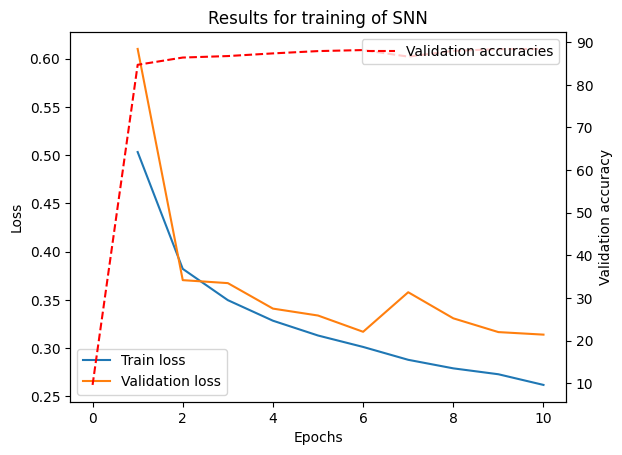

In [35]:
# Visualize results
visualize_model_training(snn_training_elapsed_time, snn_training_losses, snn_val_losses, snn_val_accs, "SNN")

## Plotting Pareto Frontiers

We plot the Pareto frontier for the models to see how different model sizes affect accuracy

In [25]:
def generate_pareto_frontier(models: dict, train_dataloader: DataLoader, val_dataloader: DataLoader, training_epochs: int=5, seed_count: int=3):
    """
    Generates Pareto frontier to compare the way parameter size affects model performance

    models is a dictionary in the form
    {"<model_name>": {}"models": list[SupervisedModel], "parameter_sizes": list[int]}}
    """
    results = {}

    for model_name in models:
        print(f"--- Training {model_name} models ---")    
        model_elapsed_time = 0    
        results[model_name] = {"accuracies": [], "parameter_sizes": []}

        for model_idx in range(len(models[model_name]["models"])):
            model = models[model_name]["models"][model_idx]

            print(f"-----\nRunning {model_name} {model_idx + 1} / {len(models[model_name]['models'])}\n")

            state_dict = model.state_dict()
            avg_acc = 0
            for seed in range(seed_count):
                print(f"-----\nRunning seed {seed + 1} / {seed_count}")
                set_torch_seed(seed)
                model.load_state_dict(state_dict)

                training_elapsed_time, _, _, val_accs = model.train(train_dataloader, val_dataloader, training_epochs)
                
                model_elapsed_time += training_elapsed_time
                avg_acc += val_accs[-1]

            results[model_name]["accuracies"].append(avg_acc / seed_count)
            results[model_name]["parameter_sizes"].append(models[model_name]["parameter_sizes"][model_idx])
            
    
    return results


models = {}

# MLPs
models["MLP"] = {"models": [], "parameter_sizes": [1, 2, 4, 8, 16, 32]}
for parameter_size in models["MLP"]["parameter_sizes"]:
    mlp = MLP(28 * 28, parameter_size, len(class_names))
    mlp_optim = optim.AdamW(mlp.parameters(), lr=0.001, weight_decay=0.0001)
    mlp_loss_fn = torch.nn.CrossEntropyLoss()
    mlp_model = TorchSM(mlp, mlp_optim, mlp_loss_fn, torch_device)

    models["MLP"]["models"].append(mlp_model)

# KANs
models["KAN"] = {"models": [], "parameter_sizes": [1, 2, 4, 8, 16, 32]}
for parameter_size in models["KAN"]["parameter_sizes"]:
    kan = ImageKAN([28 * 28, parameter_size, len(class_names)])
    kan_optim = optim.AdamW(kan.parameters(), lr=0.001, weight_decay=0.0001)
    kan_loss_fn = nn.CrossEntropyLoss()
    kan_model = TorchSM(kan, kan_optim, kan_loss_fn, torch_device)

    models["KAN"]["models"].append(kan_model)

# SNNs
models["SNN"] = {"models": [], "parameter_sizes": [1, 2, 4, 8, 16, 32]}
for parameter_size in models["SNN"]["parameter_sizes"]:
    snn = SNN(parameter_size).to("cpu")
    snn_optim = optim.AdamW(snn.parameters(), lr=0.001, weight_decay=0.0001)
    snn_loss_fn = nn.CrossEntropyLoss()
    snn_model = SNNSM(snn, snn_optim, snn_loss_fn, "cpu")

    models["SNN"]["models"].append(snn_model)


pareto_frontier = generate_pareto_frontier(models, train_dataloader, val_dataloader, training_epochs=3)

--- Training MLP models ---
-----
Running MLP 1 / 6

-----
Running seed 1 / 3


/home/moraguma/Documentos/git/Notebooks/.venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 9.317%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.737 | Validation loss: 1.507 | Validation accuracy: 35.592%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.426 | Validation loss: 1.377 | Validation accuracy: 40.667%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.339 | Validation loss: 1.317 | Validation accuracy: 46.417%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.294 | Validation loss: 1.282 | Validation accuracy: 49.708%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.268 | Validation loss: 1.263 | Validation accuracy: 50.167%

-----
Running seed 2 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 50.167%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.252 | Validation loss: 1.249 | Validation accuracy: 50.417%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.241 | Validation loss: 1.247 | Validation accuracy: 49.775%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.232 | Validation loss: 1.238 | Validation accuracy: 49.817%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.227 | Validation loss: 1.232 | Validation accuracy: 51.025%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.222 | Validation loss: 1.227 | Validation accuracy: 49.083%

-----
Running seed 3 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 49.083%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.218 | Validation loss: 1.224 | Validation accuracy: 50.625%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.214 | Validation loss: 1.222 | Validation accuracy: 50.558%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.212 | Validation loss: 1.221 | Validation accuracy: 50.150%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.210 | Validation loss: 1.220 | Validation accuracy: 49.350%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.208 | Validation loss: 1.216 | Validation accuracy: 50.908%

-----
Running MLP 2 / 6

-----
Running seed 1 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 10.792%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.189 | Validation loss: 0.892 | Validation accuracy: 66.875%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.841 | Validation loss: 0.805 | Validation accuracy: 71.067%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.782 | Validation loss: 0.771 | Validation accuracy: 71.925%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.756 | Validation loss: 0.758 | Validation accuracy: 73.000%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.739 | Validation loss: 0.749 | Validation accuracy: 72.875%

-----
Running seed 2 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 72.875%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.730 | Validation loss: 0.738 | Validation accuracy: 73.625%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.722 | Validation loss: 0.741 | Validation accuracy: 73.200%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.716 | Validation loss: 0.745 | Validation accuracy: 73.975%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.712 | Validation loss: 0.734 | Validation accuracy: 74.017%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.710 | Validation loss: 0.728 | Validation accuracy: 74.258%

-----
Running seed 3 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 74.258%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.707 | Validation loss: 0.729 | Validation accuracy: 74.133%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.705 | Validation loss: 0.732 | Validation accuracy: 73.608%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.703 | Validation loss: 0.724 | Validation accuracy: 74.383%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.701 | Validation loss: 0.723 | Validation accuracy: 74.242%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.700 | Validation loss: 0.724 | Validation accuracy: 74.683%

-----
Running MLP 3 / 6

-----
Running seed 1 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 14.675%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.838 | Validation loss: 0.623 | Validation accuracy: 79.367%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.578 | Validation loss: 0.562 | Validation accuracy: 80.542%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.535 | Validation loss: 0.534 | Validation accuracy: 81.600%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.517 | Validation loss: 0.526 | Validation accuracy: 82.017%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.504 | Validation loss: 0.521 | Validation accuracy: 82.075%

-----
Running seed 2 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 82.075%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.497 | Validation loss: 0.514 | Validation accuracy: 82.417%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.491 | Validation loss: 0.507 | Validation accuracy: 82.583%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.485 | Validation loss: 0.505 | Validation accuracy: 82.392%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.482 | Validation loss: 0.512 | Validation accuracy: 82.400%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.480 | Validation loss: 0.501 | Validation accuracy: 82.558%

-----
Running seed 3 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 82.558%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.476 | Validation loss: 0.516 | Validation accuracy: 82.025%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.475 | Validation loss: 0.500 | Validation accuracy: 82.867%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.473 | Validation loss: 0.506 | Validation accuracy: 82.775%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.471 | Validation loss: 0.496 | Validation accuracy: 82.858%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.468 | Validation loss: 0.499 | Validation accuracy: 82.925%

-----
Running MLP 4 / 6

-----
Running seed 1 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 15.892%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.694 | Validation loss: 0.522 | Validation accuracy: 82.175%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.489 | Validation loss: 0.485 | Validation accuracy: 83.617%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.456 | Validation loss: 0.461 | Validation accuracy: 84.442%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.440 | Validation loss: 0.449 | Validation accuracy: 84.875%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.429 | Validation loss: 0.455 | Validation accuracy: 84.658%

-----
Running seed 2 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 84.658%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.422 | Validation loss: 0.440 | Validation accuracy: 85.275%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.415 | Validation loss: 0.442 | Validation accuracy: 84.967%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.410 | Validation loss: 0.439 | Validation accuracy: 85.250%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.405 | Validation loss: 0.443 | Validation accuracy: 84.892%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.404 | Validation loss: 0.441 | Validation accuracy: 85.283%

-----
Running seed 3 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 85.283%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.400 | Validation loss: 0.458 | Validation accuracy: 84.317%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.399 | Validation loss: 0.445 | Validation accuracy: 84.933%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.398 | Validation loss: 0.447 | Validation accuracy: 85.225%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.393 | Validation loss: 0.446 | Validation accuracy: 84.683%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.391 | Validation loss: 0.441 | Validation accuracy: 84.967%

-----
Running MLP 5 / 6

-----
Running seed 1 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 9.500%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.619 | Validation loss: 0.486 | Validation accuracy: 83.400%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.459 | Validation loss: 0.467 | Validation accuracy: 83.875%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.433 | Validation loss: 0.446 | Validation accuracy: 84.525%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.422 | Validation loss: 0.439 | Validation accuracy: 84.925%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.413 | Validation loss: 0.440 | Validation accuracy: 85.067%

-----
Running seed 2 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 85.067%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.408 | Validation loss: 0.434 | Validation accuracy: 85.558%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.403 | Validation loss: 0.427 | Validation accuracy: 85.433%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.397 | Validation loss: 0.435 | Validation accuracy: 85.258%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.393 | Validation loss: 0.438 | Validation accuracy: 84.892%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.393 | Validation loss: 0.436 | Validation accuracy: 85.192%

-----
Running seed 3 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 85.192%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.390 | Validation loss: 0.454 | Validation accuracy: 84.292%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.388 | Validation loss: 0.449 | Validation accuracy: 85.108%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.389 | Validation loss: 0.438 | Validation accuracy: 85.542%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.384 | Validation loss: 0.444 | Validation accuracy: 84.492%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.382 | Validation loss: 0.435 | Validation accuracy: 85.183%

-----
Running MLP 6 / 6

-----
Running seed 1 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 11.367%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.575 | Validation loss: 0.477 | Validation accuracy: 83.483%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.453 | Validation loss: 0.465 | Validation accuracy: 83.958%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.430 | Validation loss: 0.451 | Validation accuracy: 84.567%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.421 | Validation loss: 0.452 | Validation accuracy: 84.542%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.413 | Validation loss: 0.439 | Validation accuracy: 85.208%

-----
Running seed 2 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 85.208%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.409 | Validation loss: 0.440 | Validation accuracy: 85.317%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.404 | Validation loss: 0.432 | Validation accuracy: 85.333%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.398 | Validation loss: 0.436 | Validation accuracy: 85.158%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.395 | Validation loss: 0.438 | Validation accuracy: 85.000%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.394 | Validation loss: 0.442 | Validation accuracy: 84.908%

-----
Running seed 3 / 3


Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 84.908%

-----
Epoch: 1 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.391 | Validation loss: 0.456 | Validation accuracy: 84.267%

-----
Epoch: 2 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.390 | Validation loss: 0.453 | Validation accuracy: 84.883%

-----
Epoch: 3 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.390 | Validation loss: 0.440 | Validation accuracy: 85.492%

-----
Epoch: 4 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.385 | Validation loss: 0.449 | Validation accuracy: 84.258%

-----
Epoch: 5 / 5


Training MLP:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating MLP:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.383 | Validation loss: 0.440 | Validation accuracy: 85.208%

--- Training KAN models ---
-----
Running KAN 1 / 6

-----
Running seed 1 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 11.808%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.773 | Validation loss: 1.459 | Validation accuracy: 47.275%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.347 | Validation loss: 1.270 | Validation accuracy: 50.875%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.191 | Validation loss: 1.173 | Validation accuracy: 54.725%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.135 | Validation loss: 1.138 | Validation accuracy: 56.075%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.111 | Validation loss: 1.119 | Validation accuracy: 56.967%

-----
Running seed 2 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 56.967%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.081 | Validation loss: 1.071 | Validation accuracy: 57.200%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.028 | Validation loss: 1.057 | Validation accuracy: 57.467%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.982 | Validation loss: 0.999 | Validation accuracy: 60.692%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.964 | Validation loss: 0.957 | Validation accuracy: 62.942%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.958 | Validation loss: 0.970 | Validation accuracy: 62.583%

-----
Running seed 3 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 62.583%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.951 | Validation loss: 0.962 | Validation accuracy: 62.700%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.948 | Validation loss: 0.989 | Validation accuracy: 61.400%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.944 | Validation loss: 0.984 | Validation accuracy: 61.358%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.943 | Validation loss: 0.956 | Validation accuracy: 63.125%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.940 | Validation loss: 0.940 | Validation accuracy: 63.525%

-----
Running KAN 2 / 6

-----
Running seed 1 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 11.900%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 1.305 | Validation loss: 0.880 | Validation accuracy: 68.275%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.797 | Validation loss: 0.766 | Validation accuracy: 71.633%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.720 | Validation loss: 0.706 | Validation accuracy: 74.217%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.676 | Validation loss: 0.703 | Validation accuracy: 74.367%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.647 | Validation loss: 0.651 | Validation accuracy: 77.283%

-----
Running seed 2 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 77.283%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.627 | Validation loss: 0.642 | Validation accuracy: 77.142%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.612 | Validation loss: 0.682 | Validation accuracy: 75.817%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.600 | Validation loss: 0.667 | Validation accuracy: 76.033%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.592 | Validation loss: 0.624 | Validation accuracy: 78.900%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.587 | Validation loss: 0.602 | Validation accuracy: 78.658%

-----
Running seed 3 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 78.658%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.578 | Validation loss: 0.607 | Validation accuracy: 78.383%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.577 | Validation loss: 0.623 | Validation accuracy: 78.817%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.573 | Validation loss: 0.625 | Validation accuracy: 77.950%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.571 | Validation loss: 0.633 | Validation accuracy: 77.825%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.565 | Validation loss: 0.598 | Validation accuracy: 79.525%

-----
Running KAN 3 / 6

-----
Running seed 1 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 8.017%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.885 | Validation loss: 0.587 | Validation accuracy: 79.842%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.534 | Validation loss: 0.525 | Validation accuracy: 82.150%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.487 | Validation loss: 0.492 | Validation accuracy: 83.008%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.465 | Validation loss: 0.497 | Validation accuracy: 82.992%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.446 | Validation loss: 0.483 | Validation accuracy: 83.283%

-----
Running seed 2 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 83.283%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.436 | Validation loss: 0.462 | Validation accuracy: 84.083%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.425 | Validation loss: 0.467 | Validation accuracy: 83.858%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.419 | Validation loss: 0.462 | Validation accuracy: 84.108%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.412 | Validation loss: 0.448 | Validation accuracy: 84.458%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.407 | Validation loss: 0.453 | Validation accuracy: 84.442%

-----
Running seed 3 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 84.442%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.400 | Validation loss: 0.450 | Validation accuracy: 84.533%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.395 | Validation loss: 0.459 | Validation accuracy: 84.267%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.393 | Validation loss: 0.446 | Validation accuracy: 84.733%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.388 | Validation loss: 0.453 | Validation accuracy: 84.142%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.386 | Validation loss: 0.451 | Validation accuracy: 84.825%

-----
Running KAN 4 / 6

-----
Running seed 1 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 10.133%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.661 | Validation loss: 0.480 | Validation accuracy: 83.100%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.441 | Validation loss: 0.453 | Validation accuracy: 84.142%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.401 | Validation loss: 0.414 | Validation accuracy: 85.183%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.381 | Validation loss: 0.392 | Validation accuracy: 86.025%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.365 | Validation loss: 0.397 | Validation accuracy: 85.883%

-----
Running seed 2 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 85.883%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.354 | Validation loss: 0.376 | Validation accuracy: 86.625%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.344 | Validation loss: 0.373 | Validation accuracy: 86.808%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.336 | Validation loss: 0.377 | Validation accuracy: 86.850%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.328 | Validation loss: 0.376 | Validation accuracy: 86.883%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.325 | Validation loss: 0.386 | Validation accuracy: 86.650%

-----
Running seed 3 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 86.650%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.317 | Validation loss: 0.377 | Validation accuracy: 86.508%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.314 | Validation loss: 0.378 | Validation accuracy: 86.917%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.310 | Validation loss: 0.389 | Validation accuracy: 86.792%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.305 | Validation loss: 0.390 | Validation accuracy: 86.158%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.301 | Validation loss: 0.379 | Validation accuracy: 86.625%

-----
Running KAN 5 / 6

-----
Running seed 1 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 8.958%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.590 | Validation loss: 0.445 | Validation accuracy: 84.417%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.408 | Validation loss: 0.416 | Validation accuracy: 85.417%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.372 | Validation loss: 0.382 | Validation accuracy: 86.458%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.352 | Validation loss: 0.388 | Validation accuracy: 85.992%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.337 | Validation loss: 0.368 | Validation accuracy: 87.008%

-----
Running seed 2 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 87.008%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.324 | Validation loss: 0.361 | Validation accuracy: 87.025%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.313 | Validation loss: 0.369 | Validation accuracy: 86.783%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.305 | Validation loss: 0.348 | Validation accuracy: 87.658%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.296 | Validation loss: 0.358 | Validation accuracy: 87.508%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.291 | Validation loss: 0.376 | Validation accuracy: 86.817%

-----
Running seed 3 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 86.817%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.283 | Validation loss: 0.365 | Validation accuracy: 87.075%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.278 | Validation loss: 0.352 | Validation accuracy: 87.908%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.272 | Validation loss: 0.363 | Validation accuracy: 87.458%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.266 | Validation loss: 0.357 | Validation accuracy: 87.658%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.262 | Validation loss: 0.360 | Validation accuracy: 87.425%

-----
Running KAN 6 / 6

-----
Running seed 1 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 3.817%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.540 | Validation loss: 0.425 | Validation accuracy: 84.867%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.383 | Validation loss: 0.388 | Validation accuracy: 86.467%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.344 | Validation loss: 0.353 | Validation accuracy: 87.358%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.324 | Validation loss: 0.354 | Validation accuracy: 87.067%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.305 | Validation loss: 0.340 | Validation accuracy: 88.000%

-----
Running seed 2 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 88.000%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.292 | Validation loss: 0.335 | Validation accuracy: 88.125%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.281 | Validation loss: 0.330 | Validation accuracy: 88.258%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.267 | Validation loss: 0.321 | Validation accuracy: 88.358%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.258 | Validation loss: 0.327 | Validation accuracy: 88.458%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.251 | Validation loss: 0.341 | Validation accuracy: 88.192%

-----
Running seed 3 / 3


Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Validation loss: 88.192%

-----
Epoch: 1 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.241 | Validation loss: 0.331 | Validation accuracy: 88.150%

-----
Epoch: 2 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.236 | Validation loss: 0.333 | Validation accuracy: 88.325%

-----
Epoch: 3 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.227 | Validation loss: 0.339 | Validation accuracy: 88.617%

-----
Epoch: 4 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.221 | Validation loss: 0.341 | Validation accuracy: 88.183%

-----
Epoch: 5 / 5


Training ImageKAN:   0%|          | 0/1500 [00:00<?, ? batches/s]

Evaluating ImageKAN:   0%|          | 0/375 [00:00<?, ? batches/s]

Train loss: 0.216 | Validation loss: 0.341 | Validation accuracy: 88.608%

--- Training SNN models ---


{'MLP': {'accuracies': [50.05277777777778, 73.93888888888888, 82.51944444444445, 84.96944444444445, 85.14722222222223, 85.10833333333333], 'parameter_sizes': [1, 2, 4, 8, 16, 32]}, 'KAN': {'accuracies': [61.025000000000006, 78.4888888888889, 84.18333333333334, 86.38611111111112, 87.08333333333333, 88.26666666666667], 'parameter_sizes': [1, 2, 4, 8, 16, 32]}, 'SNN': {'accuracies': [], 'parameter_sizes': []}}


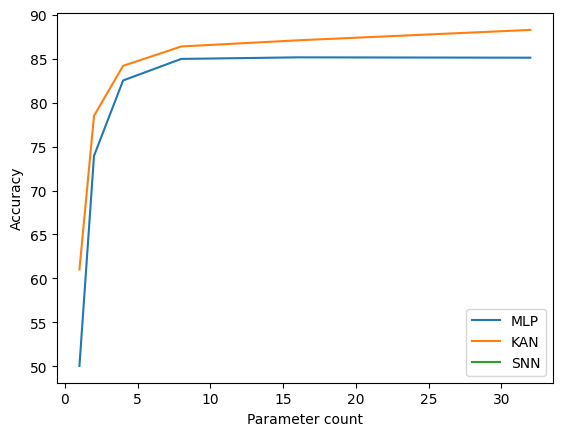

In [28]:
def plot_pareto_frontier(pareto_frontier: dict):
    """
    Plots Pareto frontier

    pareto_frontier = {"<model_name>": {"parameter_sizes": list[int], "accuracies": list[float]}}
    """
    for model_name in pareto_frontier:
        plt.plot(pareto_frontier[model_name]["parameter_sizes"], pareto_frontier[model_name]["accuracies"], label=model_name)
    
    plt.legend()
    plt.xlabel("Parameter count")
    plt.ylabel("Accuracy")
    plt.show()


print(pareto_frontier)
plot_pareto_frontier(pareto_frontier)